<h1 align="center"><strong>Model Training</strong> for Breast Cancer Wisconsin Dataset</h1>

## Dataset Source

[Kaggle: Breast Cancer Wisconsin (Diagnostic) Data Set](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data?resource=download)

# Importing Necessary Libraries

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib, warnings, tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, classification_report,
                             RocCurveDisplay)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from tensorflow.keras import layers, models, callbacks

warnings.filterwarnings("ignore")
sns.set_theme(style="ticks")
tf.random.set_seed(42)

# Load pre-processed data

In [19]:
df = pd.read_csv("../data/preprocessed_data.csv")
X, y = df.drop("diagnosis", axis=1), df["diagnosis"]

# Train / Val / Test split 60 / 20 / 20

In [20]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

splits = {
    "TRAIN": (X_train, y_train),
    "VALID": (X_val,   y_val),
    "TEST" : (X_test,  y_test),
}

# Classical ML Models

In [21]:
ml_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "KNN (k=5)"          : KNeighborsClassifier(n_neighbors=5),
    "SVC (RBF)"          : SVC(kernel="rbf", probability=True, class_weight="balanced"),
    "Random Forest"      : RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced"),
    "Gradient Boosting"  : GradientBoostingClassifier(random_state=42),
    "XGBoost"            : XGBClassifier(eval_metric="logloss", use_label_encoder=False,
                                         learning_rate=0.05, n_estimators=400, max_depth=4,
                                         subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0, random_state=42),
}


Logistic Regression – TRAIN SET
              precision    recall  f1-score   support

      Benign     0.9906    0.9860    0.9883       214
   Malignant     0.9766    0.9843    0.9804       127

    accuracy                         0.9853       341
   macro avg     0.9836    0.9851    0.9843       341
weighted avg     0.9854    0.9853    0.9853       341


Logistic Regression – VALID SET
              precision    recall  f1-score   support

      Benign     0.9857    0.9718    0.9787        71
   Malignant     0.9545    0.9767    0.9655        43

    accuracy                         0.9737       114
   macro avg     0.9701    0.9743    0.9721       114
weighted avg     0.9740    0.9737    0.9737       114


Logistic Regression – TEST SET
              precision    recall  f1-score   support

      Benign     0.9859    0.9722    0.9790        72
   Malignant     0.9535    0.9762    0.9647        42

    accuracy                         0.9737       114
   macro avg     0.9697    0.9

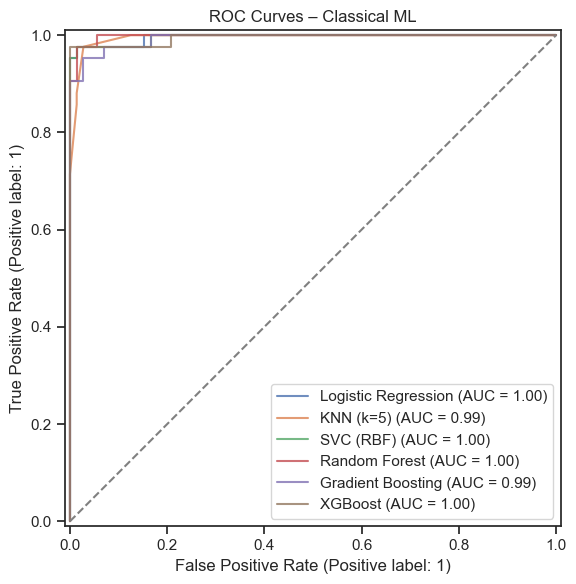

In [22]:
results = []
plt.figure(figsize=(8, 6))

for name, model in ml_models.items():
    model.fit(X_train, y_train)
    for split_name, (X_split, y_split) in splits.items():
        y_pred = model.predict(X_split)
        print(f"\n{'='*60}\n{name} – {split_name} SET\n{'='*60}")
        print(classification_report(y_split, y_pred, target_names=["Benign", "Malignant"], digits=4))

    y_test_pred  = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1]

    results.append(dict(
        Model     = name,
        Accuracy  = accuracy_score(y_test, y_test_pred),
        Precision = precision_score(y_test, y_test_pred),
        Recall    = recall_score(y_test, y_test_pred),
        F1        = f1_score(y_test, y_test_pred),
        ROC_AUC   = roc_auc_score(y_test, y_test_proba)
    ))

    RocCurveDisplay.from_predictions(y_test, y_test_proba, name=name, ax=plt.gca(), linewidth=1.5, alpha=0.8)

    # Save each model
    joblib.dump(model, f"../models/{name.replace(' ', '_').replace('(', '').replace(')', '')}.joblib")

plt.plot([0, 1], [0, 1], "--", color="gray")
plt.title("ROC Curves – Classical ML")
plt.tight_layout()
plt.show()

# Deep Learning Models

In [23]:
dl_models = {
    "MLP_Basic": models.Sequential([
        layers.Input(shape=(X_train.shape[1],)),
        layers.Dense(64, activation="relu"), layers.Dropout(0.3),
        layers.Dense(32, activation="relu"), layers.Dropout(0.2),
        layers.Dense(1,  activation="sigmoid"),
    ]),
    "MLP_Deep": models.Sequential([
        layers.Input(shape=(X_train.shape[1],)),
        layers.Dense(128, activation="relu"), layers.Dropout(0.4),
        layers.Dense(64, activation="relu"), layers.Dropout(0.3),
        layers.Dense(32, activation="relu"), layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid")
    ]),
    "CNN_1D": models.Sequential([
        layers.Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)),
        layers.Conv1D(32, kernel_size=3, activation="relu"), layers.MaxPooling1D(),
        layers.Conv1D(64, kernel_size=3, activation="relu"), layers.GlobalAveragePooling1D(),
        layers.Dense(64, activation="relu"), layers.Dropout(0.3),
        layers.Dense(1, activation="sigmoid")
    ])
}

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

MLP_Basic – TRAIN SET
              precision    recall  f1-score   support

      Benign     0.9907    1.0000    0.9953       214
   Malignant     1.0000    0.9843    0.9921       127

    accuracy                         0.9941       341
   macro avg     0.9954    0.9921    0.9937       341
weighted avg     0.9942    0.9941    0.9941       341

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

MLP_Basic – VALID SET
              precision    recall  f1-score   support

      Benign     0.9859    0.9859    0.9859        71
   Malignant     0.9767    0.9767    0.9767        43

    accuracy                         0.9825       114
   macro avg     0.9813    0.9813    0.9813       114
weighted avg     0.9825    0.9825    0.9825       114

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

MLP_Basic – TEST SET
              precision    recall  f1-score   support

      Benign     0.9726    0.9861    0.9793        72
   Malignant     0.9756    0.9524    0.9639        42

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

MLP_Deep – TRAIN SET
              precision    recall  f1-score   support

      Benign     0.9907    0.9953    0.9930       214
   Malignant     0.9921    0.9843    0.9881       127

    accuracy                         0.9912       341
   macro avg     0.9914    0.9898    0.9906       341
weighted avg     0.9912    0.9912    0.9912       341

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

MLP_Deep – VALID SET
              precision    recall  f1-score   support

      Benign     0.9855    0.9577    0.9714        71
   Malignant     0.9333    0.9767    0.9545        43

    accuracy                         0.9649       114
   macro avg     0.9594    0.9672    0.9630       114
weighted avg     0.9658    0.9649    0.9651       114

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

MLP_Deep – TEST SET
              precision    recall  f1-score   support

      Benign     0.9863    1.0000    0.9931        72
   Malignant     1.0000    0.9762    0.9880        42

 

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

CNN_1D – TRAIN SET
              precision    recall  f1-score   support

      Benign     0.9591    0.9860    0.9724       214
   Malignant     0.9752    0.9291    0.9516       127

    accuracy                         0.9648       341
   macro avg     0.9671    0.9576    0.9620       341
weighted avg     0.9651    0.9648    0.9646       341

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

CNN_1D – VALID SET
              precision    recall  f1-score   support

      Benign     0.9437    0.9437    0.9437        71
   Malignant     0.9070    0.9070    0.9070        43

    accuracy                         0.9298       114
   macro avg     0.9253    0.9253    0.9253       114
weighted avg     0.9298    0.9298    0.9298       114

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

CNN_1D – TEST SET
              precision    recall  f1-score   support

      Benign     0.9452    0.9583    0.9517        72
   Malignant     0.9268    0.9048    0.9157        42

    acc

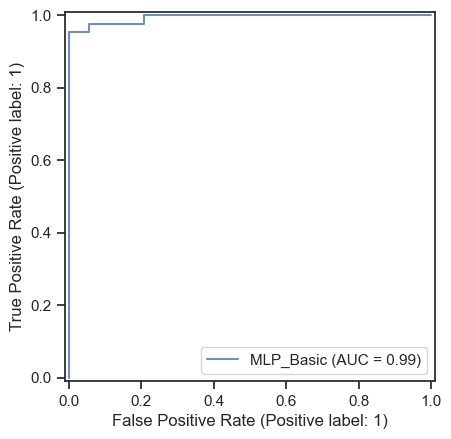

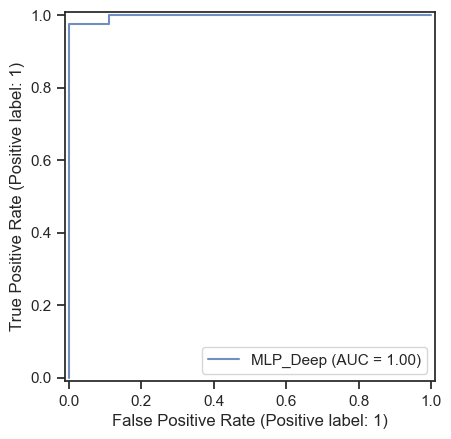

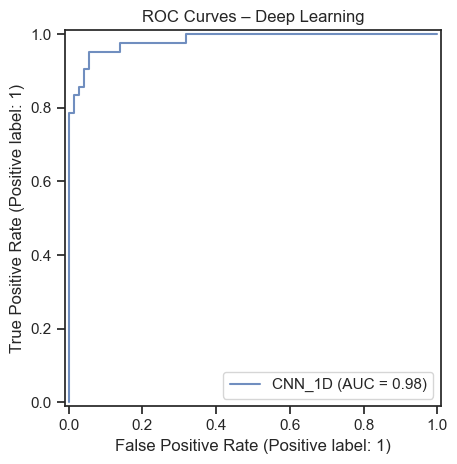

In [24]:
for name, model in dl_models.items():
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy", tf.keras.metrics.AUC(name="auc")],
    )
    early = callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )

    model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=32,
        verbose=0,
        callbacks=[early],
    )

    for split_name, (X_split, y_split) in splits.items():
        y_proba = model.predict(X_split).ravel()
        y_pred = (y_proba >= 0.5).astype(int)
        print(f"\n{'='*60}\n{name} – {split_name} SET\n{'='*60}")
        print(
            classification_report(
                y_split, y_pred, target_names=["Benign", "Malignant"], digits=4
            )
        )

    y_proba_test = model.predict(X_test).ravel()
    y_pred_test = (y_proba_test >= 0.5).astype(int)

    results.append(
        dict(
            Model=name,
            Accuracy=accuracy_score(y_test, y_pred_test),
            Precision=precision_score(y_test, y_pred_test),
            Recall=recall_score(y_test, y_pred_test),
            F1=f1_score(y_test, y_pred_test),
            ROC_AUC=roc_auc_score(y_test, y_proba_test),
        )
    )

    RocCurveDisplay.from_predictions(y_test, y_proba_test, name=name, alpha=0.8)
    model.save(f"../models/{name}.h5")

plt.title("ROC Curves – Deep Learning")
plt.tight_layout()
plt.show()

# Save Results Table

In [25]:
results_df = pd.DataFrame(results).sort_values("ROC_AUC", ascending=False)
results_df.to_csv("../models/model_results.csv", index=False)

In [26]:
print("\nModel Performance on TEST Set")
print(results_df.to_string(index=False, formatters={"ROC_AUC": "{:.3f}".format}))

print("\nAll models saved in 'models/' directory.")


Model Performance on TEST Set
              Model  Accuracy  Precision   Recall       F1 ROC_AUC
      Random Forest  0.956140   0.974359 0.904762 0.938272   0.998
           MLP_Deep  0.991228   1.000000 0.976190 0.987952   0.997
Logistic Regression  0.973684   0.953488 0.976190 0.964706   0.996
          SVC (RBF)  0.973684   0.975610 0.952381 0.963855   0.996
            XGBoost  0.973684   1.000000 0.928571 0.962963   0.995
          KNN (k=5)  0.947368   0.973684 0.880952 0.925000   0.995
          MLP_Basic  0.973684   0.975610 0.952381 0.963855   0.994
  Gradient Boosting  0.956140   0.974359 0.904762 0.938272   0.993
             CNN_1D  0.938596   0.926829 0.904762 0.915663   0.983

All models saved in 'models/' directory.


The MLP_Deep model achieved the highest overall performance, with perfect precision, excellent recall, and the best F1-score and ROC AUC. This indicates that deeper dense architectures are particularly effective at capturing the underlying patterns in this dataset.

Traditional models like Logistic Regression, SVC, and XGBoost also performed exceptionally well. This demonstrates that even with relatively simple linear or ensemble-based approaches, high accuracy can be achieved when the data is well-preprocessed and features are informative.

The CNN_1D model, while still performing well, was outperformed by both MLP architectures and several classical models. This result suggests that convolutional networks may not be the most suitable approach for purely tabular data, where spatial locality is not inherently meaningful.